In [114]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [129]:
# Dependencies
from pymongo import MongoClient
import pandas as pd
import numpy as np

from urls_list import * #where all urls and paths are saved

## Read the historic rental data

In [130]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsights["HistoricRental"].find({}, {'_id':0}))

In [166]:
DF = pd.DataFrame(records)

In [167]:
#Replace all white spaces or nothing at all to NaN
DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#Replace None with NaN
DF = DF.fillna(value=np.nan)

## Missing Data Analysis

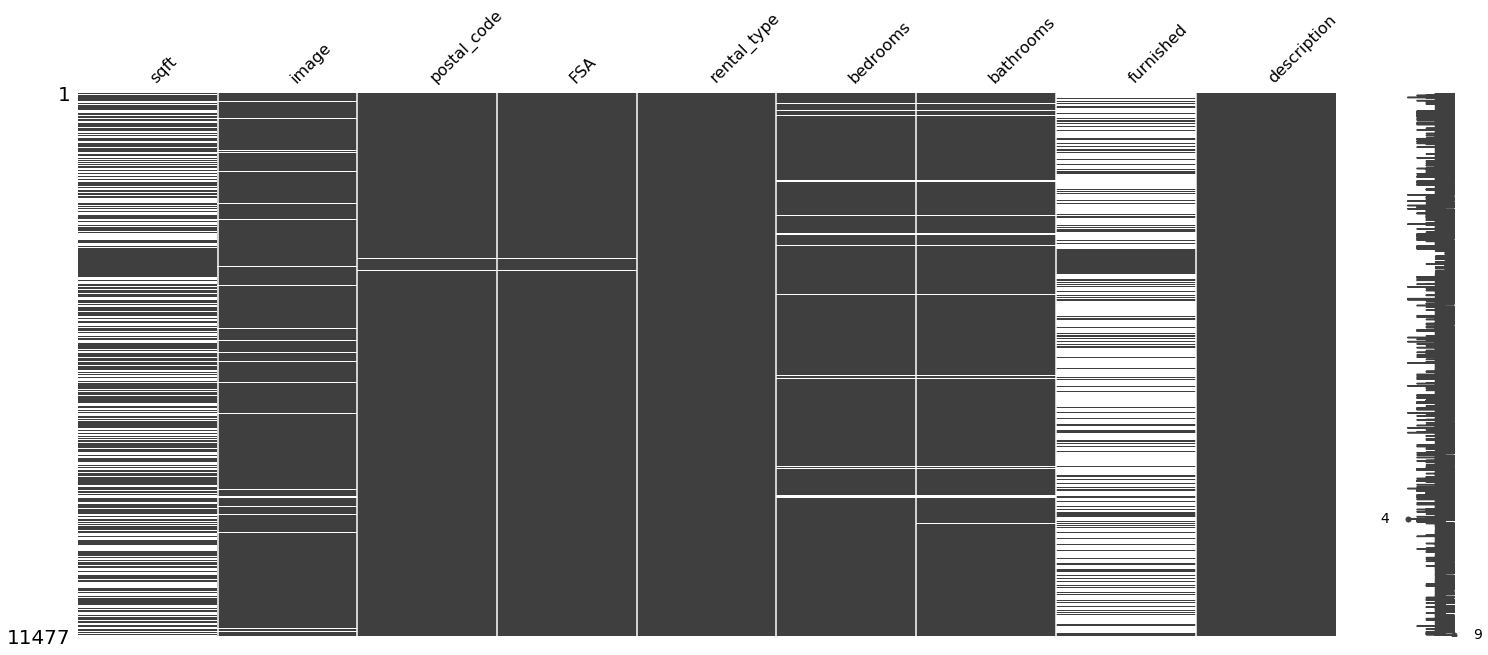

In [168]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

#### Make FSA and rental_type mandatory. If they are not retrieved in the rental posting, ML will not run, citing an exception

In [169]:
DF.drop(DF[DF[['FSA', 'rental_type']].isna().any(axis=1)].index, inplace=True)

# [1373, 3234, 3320, 3332, 3347, 3452, 3474, 3512, 3569, 3574, 3616,
#             3678, 3703, 3711, 3765, 3795, 3816, 3825, 7601, 8374, 8473, 8680,
#             9053, 9366, 9632]

In [170]:
DF = DF[DF['FSA'].str.startswith('M')]

## Type casting

In [171]:
DF['price'] = DF['price'].astype('int')

#Convert post_published_date to week of the month
from datetime import datetime
DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

#New features
DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)

## Missing value handling

In [172]:
DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
#Convert image url to image or not?
DF['image'] = DF['image'].notna()

## Removing outliers

In [173]:
#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']

#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
#DF[num_columns].quantile(0.995)
#DF[num_columns].quantile(0.005)
#DF['price'].quantile(0.995)
#DF['price'].quantile(0.005)

#Remove sqft > 3000 and less than 200
#Remove price > 10000 and less than 100

DF = DF[(DF['price']<=10000) & (DF['price']>=100)]
DF.drop(DF[(DF['sqft']<200) | (DF['sqft']>3000)].index, axis=0, inplace=True)

## Basic Transformations

In [174]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']
DF.reset_index(drop=True, inplace=True)
X = DF[num_columns + cat_columns]
Y = DF['price']


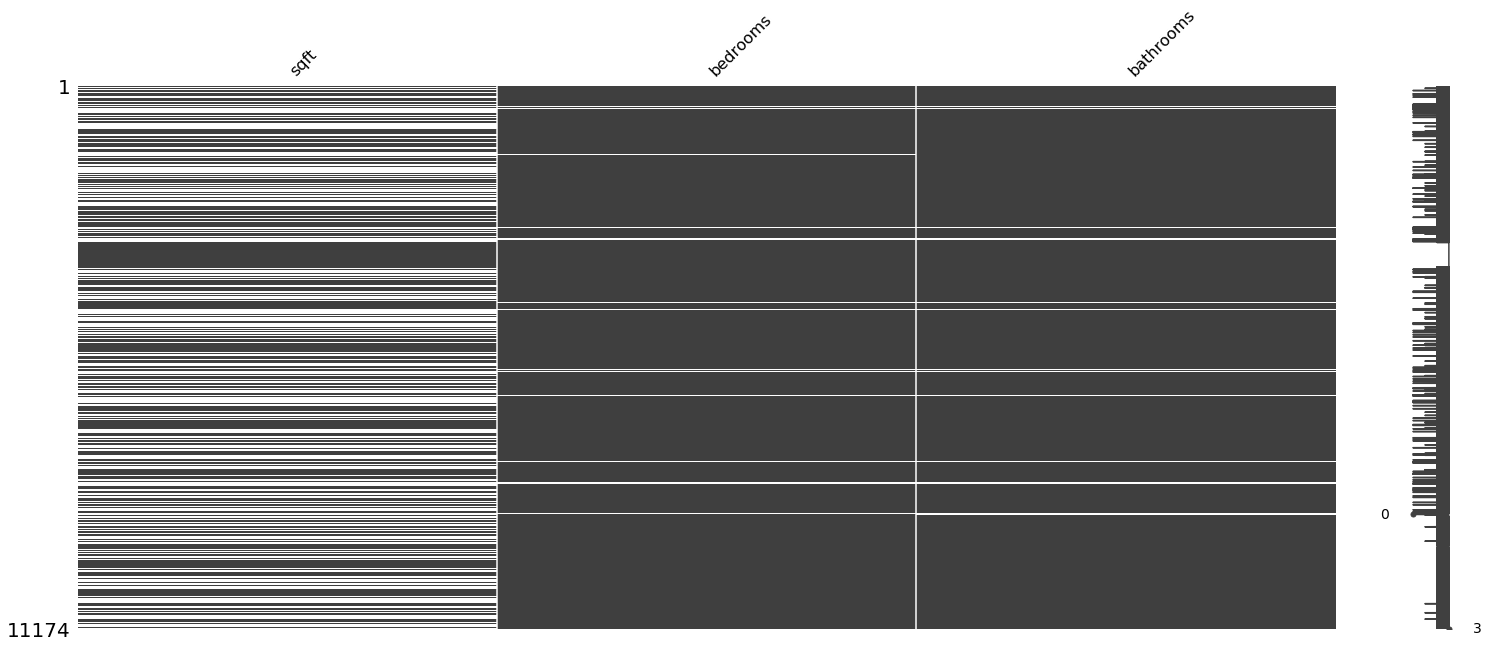

In [175]:
missingdata_col = X.columns[X.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(X[missingdata_col])

### One Hot Encoding

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
##OHE
enc = OneHotEncoder()
##OHE Fit
enc.fit(X[cat_columns])
##OHE Transform
ohe_output = enc.transform(X[cat_columns]).toarray()
##Retrieve OHE labels
ohe_dict = {f'x{index}':col for index,col in enumerate(cat_columns)}
ohe_labels = [ohe_dict[feature.split('_')[0]]+'_'+feature.split('_')[1] for feature in enc.get_feature_names()]
X = pd.concat([X, pd.DataFrame(ohe_output, columns=ohe_labels)], axis=1)
X.drop(cat_columns, axis=1, inplace=True)


OneHotEncoder()

## Train Test Split

In [177]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)


## Inference

- From the base model results, it is clear that there is overfitting.
- We need to use some feature selection methods to choose less features

In [184]:
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

#num_features = list(range(20,len(X.columns)+1,20))
num_features = [25, 30, 35]
num_features.append(len(X.columns))
scores = []
for no in num_features:
    rfe = RFE(estimator=xgb.XGBRegressor(gamma=0.01), n_features_to_select=no, verbose=5)
    xgb_model = xgb.XGBRegressor(gamma=0.01)
    pipeline = Pipeline(steps=[('feature_selection',rfe),('model',xgb_model)])
    # evaluate model
    cv = KFold(n_splits=5)
    n_scores = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise', verbose=5)
    # Append the scores for the "no" of features
    scores.append(n_scores)
    print(f"Finished {no} features")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.5min remaining: 20.3min


Finished 25 features


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.3min


Finished 30 features


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min


Finished 35 features


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.1s remaining:   48.2s


Finished 117 features


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


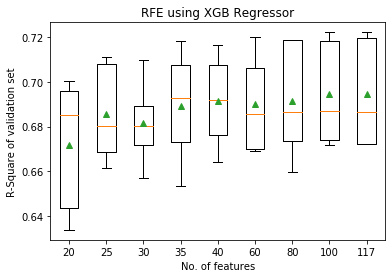

In [188]:
scores = [[0.63364091, 0.64334008, 0.68503601, 0.69585062, 0.7004957 ],
 [0.66135547, 0.68012852, 0.6684632 , 0.71124362, 0.70794003],
 [0.65692624, 0.67157828, 0.68010736, 0.68922656, 0.70980065],
 [0.65325375, 0.67292199, 0.69293267, 0.71857594, 0.70783382],
 [0.67636927, 0.66411491, 0.69194508, 0.71680965, 0.70770006],
 [0.66981596, 0.66924637, 0.68586723, 0.72016992, 0.70643464],
 [0.65981554, 0.67345238, 0.68661759, 0.71885106, 0.71895621],
 [0.67167753, 0.67400777, 0.68718622, 0.71835931, 0.72232896],
 [0.67235802, 0.67224939, 0.68649689, 0.71976075, 0.72224526]]

num_features = [20, 25, 30, 35, 40, 60, 80, 100, 117]

import matplotlib.pyplot as plt
# plot model performance for comparison
_=plt.boxplot(scores, labels=num_features, showmeans=True)
_=plt.xlabel("No. of features")
_=plt.ylabel("R-Square of validation set")
_=plt.title("RFE using XGB Regressor")
_=plt.savefig("RFE_granular.png")
_=plt.show()


# scores
# num_features

# [array([0.63364091, 0.64334008, 0.68503601, 0.69585062, 0.7004957 ]),
#  array([0.66135547, 0.68012852, 0.6684632 , 0.71124362, 0.70794003]),
#  array([0.65692624, 0.67157828, 0.68010736, 0.68922656, 0.70980065]),
#  array([0.65325375, 0.67292199, 0.69293267, 0.71857594, 0.70783382]),
#  array([0.67636927, 0.66411491, 0.69194508, 0.71680965, 0.70770006]),
#  array([0.66981596, 0.66924637, 0.68586723, 0.72016992, 0.70643464]),
#  array([0.65981554, 0.67345238, 0.68661759, 0.71885106, 0.71895621]),
#  array([0.67167753, 0.67400777, 0.68718622, 0.71835931, 0.72232896]),
#  array([0.67235802, 0.67224939, 0.68649689, 0.71976075, 0.72224526])]
# [20, 25, 30, 35, 40, 60, 80, 100, 117]

35 Looks like a good option

## Choose 35 features

In [190]:
rfe = RFE(estimator=xgb.XGBRegressor(gamma=0.01), n_features_to_select=35, verbose=5)
rfe.fit(X_train, y_train)

Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting es

RFE(estimator=XGBRegressor(base_score=None, booster=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, gamma=0.01, gpu_id=None,
                           importance_type='gain', interaction_constraints=None,
                           learning_rate=None, max_delta_step=None,
                           max_depth=None, min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None,
                           random_state=None, reg_alpha=None, reg_lambda=None,
                           scale_pos_weight=None, subsample=None,
                           tree_method=None, validate_parameters=None,
                           verbosity=None),
    n_features_to_select=35, verbose=5)

In [193]:
selected_columns = X.columns[rfe.support_]

In [195]:
top_35 = ['sqft', 'bedrooms', 'bathrooms', 'image_False', 'FSA_M1B', 'FSA_M1M',
       'FSA_M1P', 'FSA_M1V', 'FSA_M1W', 'FSA_M2M', 'FSA_M3C', 'FSA_M3K',
       'FSA_M4E', 'FSA_M4V', 'FSA_M4W', 'FSA_M5G', 'FSA_M5J', 'FSA_M5R',
       'FSA_M5S', 'FSA_M5V', 'FSA_M6B', 'FSA_M6E', 'FSA_M6G', 'FSA_M6J',
       'FSA_M6K', 'FSA_M6M', 'FSA_M6P', 'rental_type_apartment',
       'rental_type_condo', 'rental_type_house', 'rental_type_loft',
       'rental_type_townhouse', 'furnished_NOT', 'furnished_YES',
       'pet_friendly_False']

# Most important 30 features
#train_score - 0.8269937478985029, test_score - 0.6524785057215365


In [194]:
selected_columns

Index(['sqft', 'bedrooms', 'bathrooms', 'image_False', 'FSA_M1B', 'FSA_M1M',
       'FSA_M1P', 'FSA_M1V', 'FSA_M1W', 'FSA_M2M', 'FSA_M3C', 'FSA_M3K',
       'FSA_M4E', 'FSA_M4V', 'FSA_M4W', 'FSA_M5G', 'FSA_M5J', 'FSA_M5R',
       'FSA_M5S', 'FSA_M5V', 'FSA_M6B', 'FSA_M6E', 'FSA_M6G', 'FSA_M6J',
       'FSA_M6K', 'FSA_M6M', 'FSA_M6P', 'rental_type_apartment',
       'rental_type_condo', 'rental_type_house', 'rental_type_loft',
       'rental_type_townhouse', 'furnished_NOT', 'furnished_YES',
       'pet_friendly_False'],
      dtype='object')

In [196]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(gamma=0.01)#objective='reg:squarederror'
xgb_model.fit(X_train[selected_columns], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [197]:
y_pred = xgb_model.predict(X_test[selected_columns])

In [198]:
xgb_model.score(X_train[selected_columns], y_train)

0.8585862089170919

In [199]:
xgb_model.score(X_test[selected_columns], y_test)


0.7093221504839515

In [200]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))
# np.sqrt(np.mean((y_pred-y_test)**2))

0.7093221504839515

453.588539964948

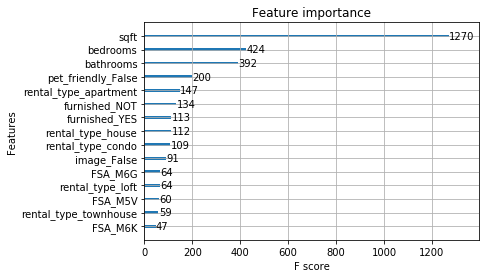

In [202]:
from xgboost import plot_importance
plot_importance(xgb_model, max_num_features=15) # top 15 most important features